In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random
import json
import os
import pandas as pd

In [2]:
%cd ..

f:\ProjectSolar\ProjectSolar-20240704_v0


In [3]:
config_path = 'data/TUDelft/output_20240905_010719/config.json'
ground_truth_path = 'data/TUDelft/measured_data.csv'


In [4]:
with open(config_path, 'r') as file:
    CONFIG = json.load(file)
    print(CONFIG)

{'area_per_point': 9, 'azimuth_resolution': 5, 'elevation_resolution': 5, 'epw_file': 'rotterdam.epw', 'global_irradiance_time': 1834.2714636325836, 'irradiance_batch_size': 500, 'irradiance_model': 'isotropic', 'num_bounces': 5, 'output_folder_name': 'output_20240905_010719', 'result': {'bbox_max': [85675.1015625, 446983.46875, 95.04199981689453], 'bbox_min': [84501.5625, 445805.0, -3.7470016479492188], 'global_irradiance_time': 5625.92919254303, 'num_timesteps': 9, 'shadow_calculation_time': 0.14489661157131195, 'viewshed_rendering_time': 25.597991943359375, 'voxel_dim_x': 131, 'voxel_dim_y': 131, 'voxel_dim_z': 11}, 'scenario': 'tud', 'study_area': {'data_root': './data/TUDelft', 'end_time': '2020-09-22 00:00:00', 'frequency': 'h', 'lat': 52.00091589108101, 'long': 4.372930257905266, 'start_time': '2020-09-21 00:00:00', 'timezone': 'Europe/Amsterdam'}, 'voxel_resolution': 9}


In [5]:
folder_path = CONFIG['study_area']['data_root']
data_root = os.path.join(folder_path, CONFIG['output_folder_name'])
point_grid_path = os.path.join(data_root, 'intermediate', 'point_grid.dat')
index_map_path = os.path.join(data_root,  'index_map.dat')
shadow_map_path = os.path.join(data_root, 'shadow_map.dat')
sun_pos_path = os.path.join(data_root, 'intermediate', 'sun_pos.csv')


horizon_factor_path = os.path.join(data_root, 'horizon_factor_map.dat')
sky_view_factor_path = os.path.join(data_root,  'sky_view_factor_map.dat')
cosine_map_path = os.path.join(data_root, 'cosine_map.dat')

voxel_size = CONFIG['voxel_resolution']
num_azimuth = 360//CONFIG['azimuth_resolution']
num_elevation = 90//CONFIG['elevation_resolution']
print(num_azimuth, num_elevation)
num_samples = num_azimuth*num_elevation
index_dim = (num_elevation,num_azimuth)

estimated_irradiance_path = os.path.join(data_root, 'irradiance.npy')
weather_data_path = os.path.join(data_root, 'weather_data.npy')

point_grid = np.loadtxt(point_grid_path)
estimated_irradiance = np.load(estimated_irradiance_path)
# weather_data = np.load(weather_data_path)

72 18


In [6]:
def print_point_info(point_grid, horizon_factor_path, sky_view_factor_path, index_map_path, cosine_map_path, index_dim, point_idx):
    horizon_factor_path = np.memmap(horizon_factor_path, dtype=np.float16, mode='r')
    sky_view_factor_path = np.memmap(sky_view_factor_path, dtype=np.int32, mode='r')
    index_map = np.memmap(index_map_path, dtype=np.uint32, mode='r')
    # cosine_map = np.memmap(cosine_map_path, dtype=np.float16, mode='r')

    num_samples = index_dim[0]*index_dim[1]
    index_start = point_idx*num_samples
    index_end = (point_idx+1)*num_samples

    voxel_indices = index_map[index_start:index_end]
    # breakpoint()
    voxel_indices = voxel_indices.reshape(index_dim)
    unique_values = np.unique(voxel_indices)

    # sum_of_cosine = np.sum(cosine_map[index_start*6:index_end*6])
    # print("sum of cosine: ", sum_of_cosine)

    # 创建一个随机颜色映射，确保白色为最大值对应的颜色
    colors = {}
    for value in unique_values:
        # print(value)
        if value == 4294967295:
            colors[value] = (1.0, 1.0, 1.0)  # 白色
        else:
            colors[value] = (random.random(), random.random(), random.random())

    # 将图像数据转换为 RGB
    image = np.zeros((voxel_indices.shape[0], voxel_indices.shape[1], 3))

    for i in range(voxel_indices.shape[0]):
        for j in range(voxel_indices.shape[1]):
            image[i, j] = colors[voxel_indices[i, j]]

    # image = np.flipud(image)
    plt.xticks(np.linspace(0, voxel_indices.shape[1] - 1, num=5), 
           labels=np.linspace(0, 360, num=5).astype(int))  # 横轴 azimuth 从 0 到 360 度

    plt.yticks(np.linspace(0, voxel_indices.shape[0] - 1, num=4), 
            labels=np.linspace(90, 0, num=4).astype(int))  # 纵轴 elevation 从 0 到 90 度

    # 添加坐标轴标签
    plt.xlabel('Azimuth (degrees)')
    plt.ylabel('Elevation (degrees)')

    plt.imshow(image)
    # plt.savefig('S3.png', bbox_inches='tight', pad_inches=0, dpi=300)
    # plt.axis('off')  # 隐藏坐标轴
    plt.show()

    print("sky view factor: ", sky_view_factor_path[point_idx]/num_samples)
    print("horizon factor: ", horizon_factor_path[point_idx])
    formatted_values = [f"{x:.5f}" for x in point_grid[point_idx]]
    print("point info: ", formatted_values)

    



In [17]:
def obtain_tud(ground_recording_filename, sunpos_filename):
    sunpos = pd.read_csv(sunpos_filename)
    sunpos.columns.values[0]='timestamp'
    ground_recording = pd.read_csv(ground_recording_filename)
    sunpos['timestamp'] = pd.to_datetime(sunpos['timestamp']).dt.tz_localize(None)
    ground_recording['local_time'] = pd.to_datetime(ground_recording['local_time'])
    filtered_ground_recording = ground_recording[ground_recording['local_time'].isin(sunpos['timestamp'])]

    ground_measurement = filtered_ground_recording.copy()
    ground_measurement['zenith_angle'] = 90 - ground_measurement['sun_altitude']

    # 将天顶角从度数转换为弧度
    ground_measurement['theta_radians'] = np.radians(ground_measurement['zenith_angle'])

    # 计算 GHI
    ground_measurement['GHI'] = ground_measurement['DHI'] + ground_measurement['DNI'] * np.cos(ground_measurement['theta_radians'])

    # 如果不需要 'theta_radians' 和 'zenith_angle' 列，可以将其删除
    ground_measurement.drop(columns=['theta_radians', 'zenith_angle'], inplace=True)

    
    return ground_measurement

In [8]:
def calculate_metrics(y_true, y_pred):
    # 计算均值
    mean_y_true = np.mean(y_true)
    
    # Pearson Correlation Coefficient
    correlation = np.corrcoef(y_true, y_pred)[0, 1]
    
    # nMBE (normalized Mean Bias Error)
    mbe = np.mean(y_pred - y_true)
    nMBE = mbe / mean_y_true
    
    # nMAE (normalized Mean Absolute Error)
    mae = np.mean(np.abs(y_pred - y_true))
    nMAE = mae / mean_y_true
    
    # nRMSE (normalized Root Mean Squared Error)
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    nRMSE = rmse / mean_y_true
    
    return correlation, nMBE, nMAE, nRMSE

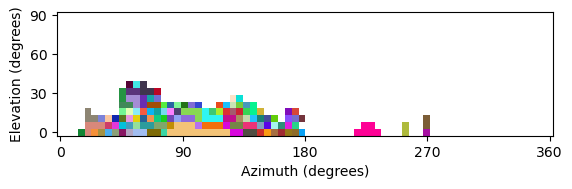

sky view factor:  0.8726851851851852
horizon factor:  0.0
point info:  ['85070.55469', '446187.56250', '13.52845', '0.00000', '-0.46191', '0.88693', '0.40000', '0.01445', '1119236.00000', '55241912.00000']


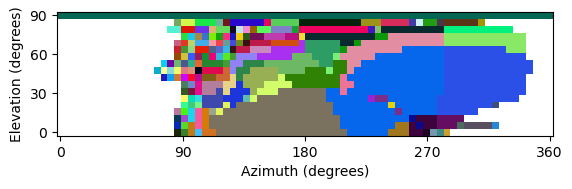

sky view factor:  0.3055555555555556
horizon factor:  nan
point info:  ['85078.92188', '446190.53125', '13.76164', '0.92308', '0.38461', '0.00000', '0.40000', '0.00762', '1130787.00000', '19125524.00000']


In [9]:
s1_idx = 1119236 # s1
s2_idx = 1130787 # s2
print_point_info(point_grid, horizon_factor_path, sky_view_factor_path, index_map_path, cosine_map_path, index_dim, s1_idx)
print_point_info(point_grid, horizon_factor_path, sky_view_factor_path, index_map_path, cosine_map_path, index_dim, s2_idx)

In [18]:
ground_measurement = obtain_tud(ground_truth_path, sun_pos_path)

In [19]:
ground_measurement

,local_time,time_zone,valid,DHI,DNI,sun_azimuth,sun_altitude,S1,S2,GHI
23982,2020-09-21 11:00:00,2,1,112.673774,739,134.138272,29.055067,653.30,407,471.569116
24042,2020-09-21 12:00:00,2,1,117.168233,791,150.539195,34.683063,801.80,224,567.276077
24102,2020-09-21 13:00:00,2,1,119.293000,822,168.761281,37.884916,883.70,178,624.064653
24162,2020-09-21 14:00:00,2,1,120.086874,815,187.829969,38.143892,881.90,188,623.462274
24222,2020-09-21 15:00:00,2,1,116.589670,788,206.287544,35.412949,809.60,187,573.208386
24282,2020-09-21 16:00:00,2,1,112.810278,719,223.025977,30.142981,659.50,162,473.863027
24342,2020-09-21 17:00:00,2,1,90.879556,663,237.809197,23.017159,475.60,117,350.117057
24402,2020-09-21 18:00:00,2,1,63.458085,537,251.015928,14.682816,250.10,68,199.570311
24462,2020-09-21 19:00:00,2,1,32.413007,256,263.226216,5.682023,55.07,29,57.758936


In [20]:
def plot_irradiance(ground_measurement, estimated_irradiance, s1_idx, s2_idx):
    plt.figure(figsize=(12, 8))

    for i in range(estimated_irradiance.shape[0]):
        plt.plot(estimated_irradiance[i][s1_idx], label=f"Bounce {i}", marker='o')
        correlation, nMBE, nMAE, nRMSE = calculate_metrics(ground_measurement['S1'].values, estimated_irradiance[i][s1_idx])
        print(f"Bounce {i} correlation: {correlation}, nMBE: {nMBE}, nMAE: {nMAE}, nRMSE: {nRMSE}")

    simplified_prediction = estimated_irradiance[0][s1_idx] + ground_measurement['GHI'].values * 0.2

    correlation, nMBE, nMAE, nRMSE = calculate_metrics(ground_measurement['S1'].values, simplified_prediction)
    print(f"Simplified evaluation: {correlation}, nMBE: {nMBE}, nMAE: {nMAE}, nRMSE: {nRMSE}")
    plt.plot(simplified_prediction, label="Simplified prediction", marker='o')

    plt.plot(ground_measurement['S1'].values, label="S1 ground measurements", marker='o')
    

    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.title("Comparison of Estimated Irradiance and Weather Data")
    plt.legend()
    plt.grid(True)
    # plt.savefig('S3.png', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()


    plt.figure(figsize=(12, 8))

    for i in range(estimated_irradiance.shape[0]):
        plt.plot(estimated_irradiance[i][s2_idx], label=f"Bounce {i}", marker='o')
        correlation, nMBE, nMAE, nRMSE = calculate_metrics(ground_measurement['S2'].values, estimated_irradiance[i][s2_idx])
        print(f"Bounce {i} correlation: {correlation}, nMBE: {nMBE}, nMAE: {nMAE}, nRMSE: {nRMSE}")

    simplified_prediction = estimated_irradiance[0][s2_idx] + ground_measurement['GHI'].values * 0.2
    correlation, nMBE, nMAE, nRMSE = calculate_metrics(ground_measurement['S2'].values, simplified_prediction)
    print(f"Simplified evaluation: {correlation}, nMBE: {nMBE}, nMAE: {nMAE}, nRMSE: {nRMSE}")
    plt.plot(simplified_prediction, label="Simplified prediction", marker='o')

    plt.plot(ground_measurement['S2'].values, label="S2 ground measurements", marker='o')

    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.title("Comparison of Estimated Irradiance and Weather Data")
    plt.legend()
    plt.grid(True)
    # plt.savefig('S3.png', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()

Bounce 0 correlation: 0.9999312068724694, nMBE: -0.038476622710440646, nMAE: 0.043870990527696975, nRMSE: 0.04834349552249888
Bounce 1 correlation: 0.9997683013301392, nMBE: 0.004389400622947001, nMAE: 0.02042580074506785, nRMSE: 0.024815365146720683
Bounce 2 correlation: 0.9997174742477585, nMBE: 0.016558955631856616, nMAE: 0.020723371923646206, nRMSE: 0.027538658494067683
Bounce 3 correlation: 0.9996984317077626, nMBE: 0.020833997949037637, nMAE: 0.022944571040784487, nRMSE: 0.02977413433366257
Bounce 4 correlation: 0.9996909653263307, nMBE: 0.022923520611492682, nMAE: 0.024267661918702946, nRMSE: 0.03100029372367114
Bounce 5 correlation: 0.999686143753817, nMBE: 0.024078694110577788, nMAE: 0.02515575425030033, nRMSE: 0.031729641033806835
Simplified evaluation: 0.9999403427365934, nMBE: 0.10559939997642705, nMAE: 0.10559939997642705, nRMSE: 0.11069378250370779


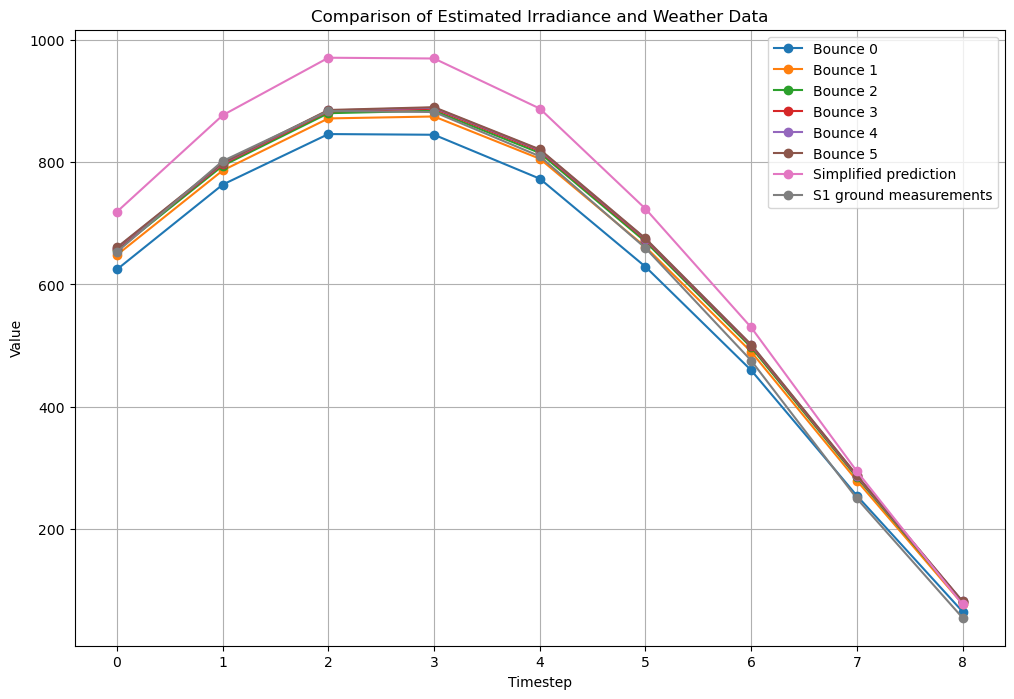

Bounce 0 correlation: 0.9071757277411232, nMBE: -0.6134561458819325, nMAE: 0.6134561458819325, nRMSE: 0.6630602478773753
Bounce 1 correlation: 0.970183403287319, nMBE: 0.3875068311158942, nMAE: 0.3875068311158942, nRMSE: 0.4156592601872309
Bounce 2 correlation: 0.9580292097111582, nMBE: 0.8793914103377025, nMAE: 0.8793914103377025, nRMSE: 0.8997191455115547
Bounce 3 correlation: 0.9441712700175877, nMBE: 1.1637853362028372, nMAE: 1.1637853362028372, nRMSE: 1.192731123564674
Bounce 4 correlation: 0.9354889903749513, nMBE: 1.3360765556929508, nMAE: 1.3360765556929508, nRMSE: 1.3714501974672377
Bounce 5 correlation: 0.9299603982907783, nMBE: 1.4436168884973424, nMAE: 1.4436168884973424, nRMSE: 1.4832367043532906
Simplified evaluation: 0.9931324931516361, nMBE: -0.1082138590677674, nMAE: 0.11177671980926289, nRMSE: 0.1284733950787865


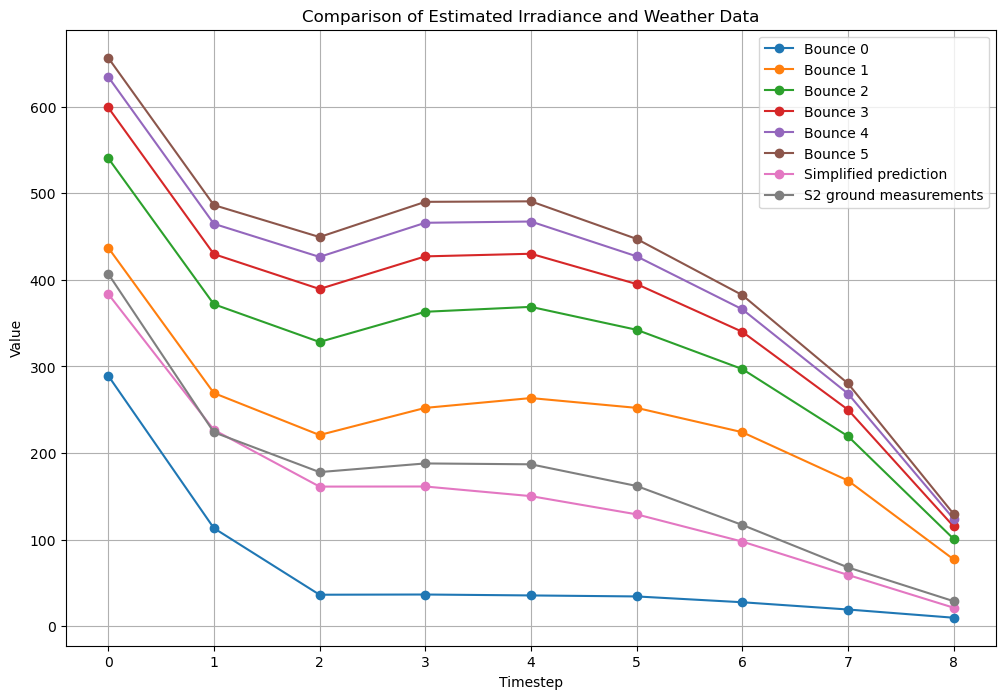

In [21]:
plot_irradiance(ground_measurement, estimated_irradiance, s1_idx, s2_idx)

In [13]:
# plot_irradiance(ground_measurement, estimated_irradiance, s1_idx, s2_idx)